In [1]:
# Team menbers        ID
# Jufeng Yang         20125011
# Xingda Zhou         19107471
# Zhongen Qin         19107579 

# Import numpy, imutils, os, PIL, skimage and so on
# import skimage color and transform
import numpy as np
import imutils
import os
import scipy.ndimage
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io
from skimage.color import rgba2rgb, rgb2hsv, rgb2gray, gray2rgb
from skimage.transform import resize

The dimension of all pictures:
(28, 960, 1280, 4)


One picture:


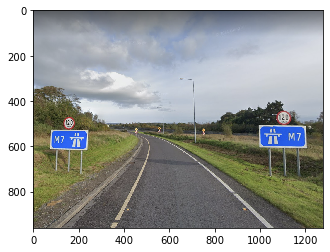

In [6]:
# Define a method to read all images from memory
def load_images_from_folder(folder):
    # Create a list data of images
    images = []
    # Go through the folder and output the filename 
    for filename in os.listdir(folder):
        # Read the pictures
        #img = plt.imread(os.path.join(folder,filename))
        img = imutils.imread(os.path.join(folder,filename), greyscale = False)
        # to append data to a image variable
        if img is not None:
            images.append(img)
    return images

# Check the method works or not
images_rgba = load_images_from_folder('./speed-sign-test-images/')
images_rgba = np.array(images_rgba)
print("The dimension of all pictures:") 
print(images_rgba.shape)
#for i in range(0, images_rgba.shape[0]):
#    imutils.imshow(images_rgba[i,:,:,:])

# Print 1 picture
print("\n\nOne picture:")
imutils.imshow(images_rgba[6,:,:,:])

The HSV image: 


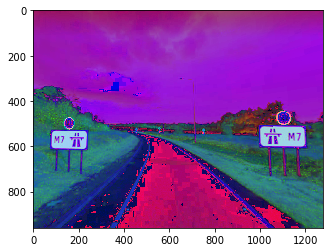



H channel: 


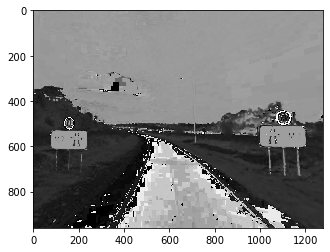



S channel: 


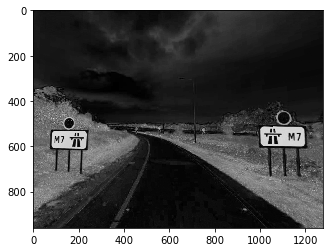



V channel: 


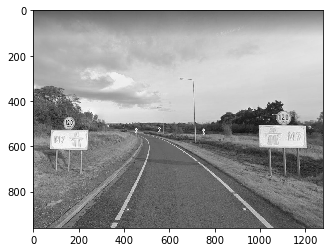

In [7]:
#for i in range(0, images_rgba.shape[0]):
#    imutils.imshow(images_rgba[i,:,:,:])
# Convert all RGBA pictures into RGB
images_rgb = rgba2rgb(images_rgba[6,:,:,:])
# Convert RGB to HSV
images_hsv = rgb2hsv(images_rgb)
#images_gray = rgb2gray(images_rgb)
# Show the hsv image
print("The HSV image: ")
imutils.imshow(images_hsv)

# Seperate the HSV channel
images_h = images_hsv[:,:,0]
images_s = images_hsv[:,:,1]
images_v = images_hsv[:,:,2]

# Show all channels
print("\n\nH channel: ")
imutils.imshow(images_h)

print("\n\nS channel: ")
imutils.imshow(images_s)

print("\n\nV channel: ")
imutils.imshow(images_v)

Hue Threshold ( > 0.85):


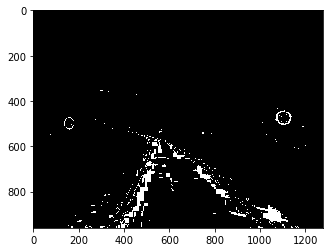



Sat Threshold ( > 0.3):


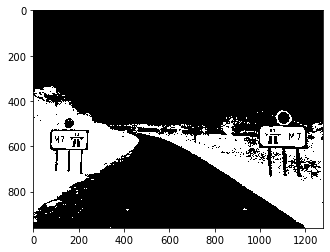



Val Threshold ( > 0.22):


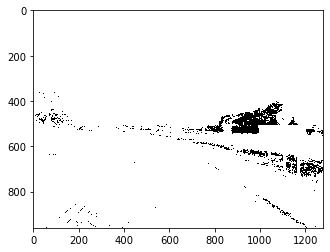



Combined all threshold into a Mask:


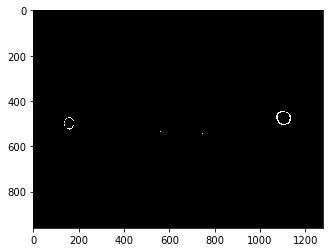

In [8]:
# Create a mask for the H channel
print("Hue Threshold ( > 0.85):")
Hue_mask_low = images_h > 0.85
imutils.imshow(Hue_mask_low)

# Create a mask for the S channel
print("\n\nSat Threshold ( > 0.3):")
Sat_mask_low = images_s > 0.3
imutils.imshow(Sat_mask_low)

# Create a mask for the V channel
print("\n\nVal Threshold ( > 0.22):")
Val_mask_low = images_v > 0.22
imutils.imshow(Val_mask_low)

# Conbine all mask together
print("\n\nCombined all threshold into a Mask:")
Mask = Hue_mask_low*Sat_mask_low*Val_mask_low
imutils.imshow(Mask)

After enhance: 


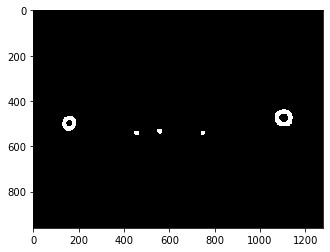


After elimination: 


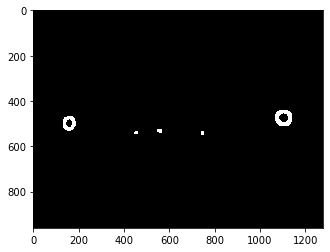

After label:


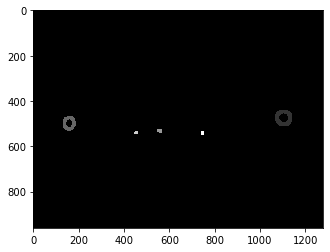

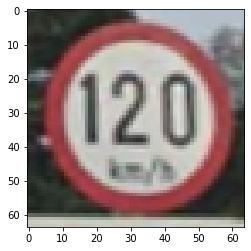

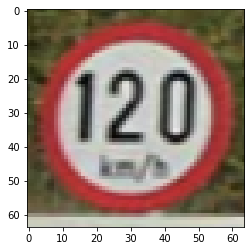

Labelde image eliminaate the small region:


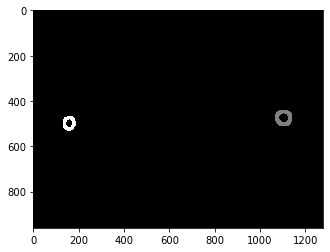

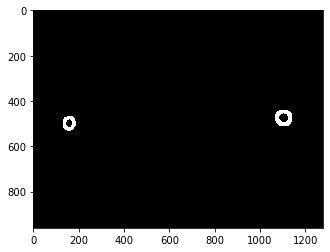

In [10]:
# Call a filter to enhanced ROI 
print("After enhance: ")
Mask_max = scipy.ndimage.maximum_filter(Mask, size = 13)
imutils.imshow(Mask_max)

# Call a binary erosion to eliminate data
print("\nAfter elimination: ")
Mask_erosion = scipy.ndimage.binary_erosion(Mask_max)
imutils.imshow(Mask_erosion)

# Label those ROIs
print("After label:")
Mask_labeled, num = scipy.ndimage.label(Mask_erosion)
imutils.imshow(Mask_labeled)

# A list variable
speed_signs = []
# A for loop to go through all labels
for i in range(1, num+1):
    # Use i to filte labels reseparatly 
    label_region = (Mask_labeled==i).astype(np.uint8)
    # Return all rowa and colums of nonzero
    row, colum = np.nonzero(label_region)
    # Use try to avoid the ValueError
    try:
        # Calulate the area of ROI
        label_area = ( np.amax(row) - np.amin(row) ) * (np.amax(colum) - np.amin(colum))
        # Use the condition to eliminate the small region
        if label_area < 1000:
            # Assign those small light point into 0.
            Mask_labeled[np.amin(row)-2: np.amax(row)+2, np.amin(colum)-2: np.amax(colum)+2] = 0
            Mask_erosion[np.amin(row)-2: np.amax(row)+2, np.amin(colum)-2: np.amax(colum)+2] = 0
        else:
            # Define variables to store positions of ROI
            Xmax = np.array([])
            Xmin = np.array([]) 
            Ymax = np.array([]) 
            Ymin = np.array([])
            
            # Return the position of Min and Max of X Y axis 
            #np.append(Xmax, np.amax(row))
            #np.append(Xmin, np.amin(row))
            #np.append(Ymax, np.amax(colum))
            #np.append(Ymin, np.amin(colum))
            
            Xmax = np.append(Xmax, np.amax(row))
            Xmin = np.append(Xmin, np.amin(row))
            Ymax = np.append(Ymax, np.amax(colum))
            Ymin = np.append(Ymin, np.amin(colum))
            # Frame the ROI and return it 
            speed_sign = images_rgb[np.amin(row): np.amax(row), np.amin(colum): np.amax(colum),:]
            #spped_sign = gray2rgb(speed_sign)
            
            # Resize speed sign rigion into 64*64
            speed_sign = resize(speed_sign, (64,64,3))
            # more than 1 speed signs, stored use append
            speed_signs.append(speed_sign)
            imutils.imshow(speed_sign)
    except ValueError:
        pass  
# Show the process result 
print("Labelde image eliminaate the small region:")
imutils.imshow(Mask_labeled)
imutils.imshow(Mask_erosion)


In [14]:
def speed_sign_detector(images_rgba):
    
    # Convert all RGBA pictures into RGB
    # Convert RGB to HSV
    images_rgb = rgba2rgb(images_rgba)
    images_hsv = rgb2hsv(images_rgb)
    
    # Separate H S V channels
    images_h = images_hsv[:,:,0]
    images_s = images_hsv[:,:,1]
    images_v = images_hsv[:,:,2]
    
    # Built Masks for H, S, V channels
    Hue_mask_low = images_h > 0.85

    Sat_mask_low = images_s > 0.3

    Val_mask_low = images_v > 0.22
    
    # Conbine all masks into a whole mask
    Mask = Hue_mask_low*Sat_mask_low*Val_mask_low
    
    # Call a filter to enhanced ROI 
    Mask_max = scipy.ndimage.maximum_filter(Mask, size = 17)

    # Call a binary erosion to eliminate data
    Mask_erosion = scipy.ndimage.binary_erosion(Mask_max)

    # Label those ROIs
    Mask_labeled, num = scipy.ndimage.label(Mask_erosion)

    # Define variable to store the image data and positions of ROIs
    speed_signs = []
    Xmax = np.array([])
    Xmin = np.array([]) 
    Ymax = np.array([]) 
    Ymin = np.array([])
    
    # A for loop to go through all labels
    for i in range(1, num+1):
        # Use i to filte labels reseparatly 
        label_region = (Mask_labeled==i).astype(np.uint8)
        # Return all rowa and colums of nonzero
        row, colum = np.nonzero(label_region)
        # Use try to avoid the ValueError
        try:
            # Calulate the area of ROI
            label_area = ( np.amax(row) - np.amin(row) ) * (np.amax(colum) - np.amin(colum))
            # Use the condition to eliminate the small region
            if label_area < 1000:
                Mask_labeled[np.amin(row)-2: np.amax(row)+2, np.amin(colum)-2: np.amax(colum)+2] = 0
                Mask_erosion[np.amin(row)-2: np.amax(row)+2, np.amin(colum)-2: np.amax(colum)+2] = 0
            else:
                # Define variables to store positions of ROI
                Xmax = np.append(Xmax, np.amax(row))
                Xmin = np.append(Xmin, np.amin(row))
                Ymax = np.append(Ymax, np.amax(colum))
                Ymin = np.append(Ymin, np.amin(colum))
                # Frame the ROI and return it
                speed_sign = images_rgb[np.amin(row): np.amax(row), np.amin(colum): np.amax(colum),:]
                #spped_sign = gray2rgb(speed_sign)
                # Resize speed sign rigion into 64*64
                speed_sign = resize(speed_sign, (64,64,3))
                # Convert the RBG to Gray, which use for classfier
                speed_sign = rgb2gray(speed_sign)
                # more than 1 speed signs, stored use append
                speed_signs.append(speed_sign)
        except ValueError:
            pass
    return speed_signs, Xmax, Xmin, Ymax, Ymin

[322.] [253.]
(1, 64, 64)
[0.63024445 0.7128339  0.73536131 ... 0.28114762 0.29767099 0.33283173]
(1, 0)


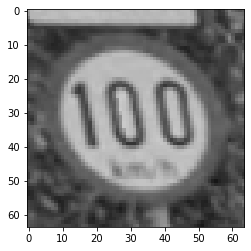

[843.] [687.]
(1, 64, 64)
[0.42214075 0.42787211 0.42765341 ... 0.16128209 0.16239645 0.18189289]
(1, 0)


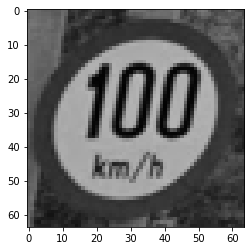

[683.] [599.]
(1, 64, 64)
[0.3982743  0.43214818 0.4204611  ... 0.5253004  0.51646774 0.50876038]
(1, 0)


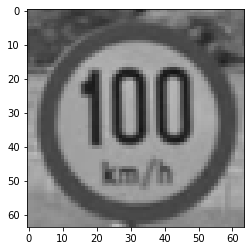

[661.] [410.]
(1, 64, 64)
[0.23473542 0.16725735 0.13660048 ... 0.19982452 0.25743834 0.24896561]
(1, 0)


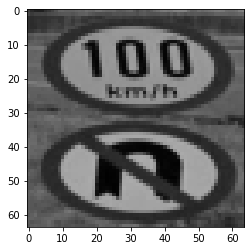

[665.] [595.]
(1, 64, 64)
[0.04319408 0.03072499 0.02024757 ... 0.1096567  0.09399149 0.07316965]
(1, 0)


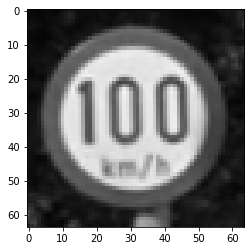

[649.] [486.]
(1, 64, 64)
[0.19588687 0.24701795 0.32970061 ... 0.29716578 0.29381998 0.28590261]
(1, 0)


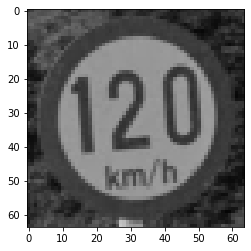

[513. 533.] [437. 465.]
(2, 64, 64)
[0.23134066 0.3040559  0.39951175 ... 0.7943848  0.80483853 0.79639268]
(1, 0)


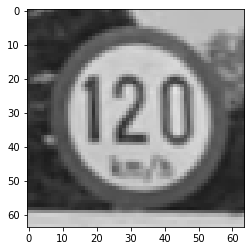

(2, 64, 64)
[0.23134066 0.3040559  0.39951175 ... 0.7943848  0.80483853 0.79639268]
(1, 0)


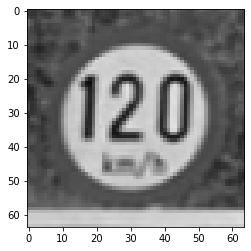

[388. 434.] [285. 406.]
(2, 64, 64)
[0.73181647 0.73181647 0.73181647 ... 0.62366939 0.53369228 0.50527846]
(1, 0)


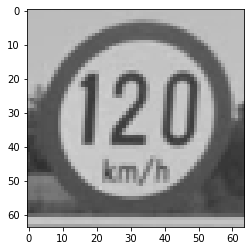

(2, 64, 64)
[0.73181647 0.73181647 0.73181647 ... 0.62366939 0.53369228 0.50527846]
(1, 0)


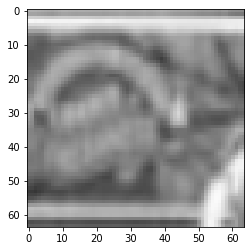

[268. 521. 541. 551.] [209. 320. 506. 514.]
(4, 64, 64)
[0.44526527 0.44514717 0.4431984  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


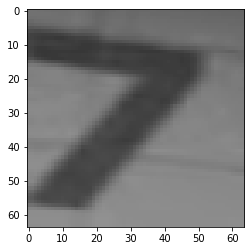

(4, 64, 64)
[0.44526527 0.44514717 0.4431984  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


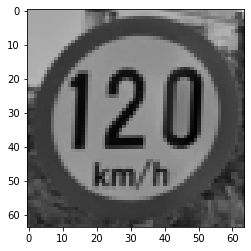

(4, 64, 64)
[0.44526527 0.44514717 0.4431984  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


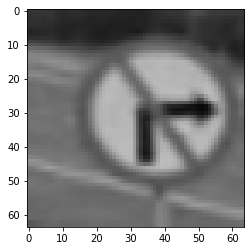

(4, 64, 64)
[0.44526527 0.44514717 0.4431984  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


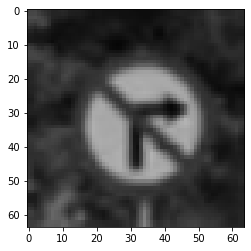

[372. 459. 469.] [189. 424. 432.]
(3, 64, 64)
[0.76155488 0.77159568 0.7807081  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


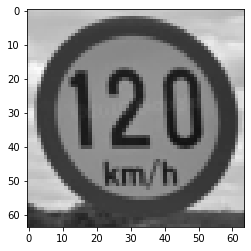

(3, 64, 64)
[0.76155488 0.77159568 0.7807081  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


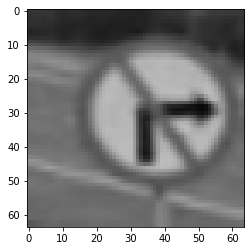

(3, 64, 64)
[0.76155488 0.77159568 0.7807081  ... 0.13463322 0.14404255 0.14701392]
(1, 0)


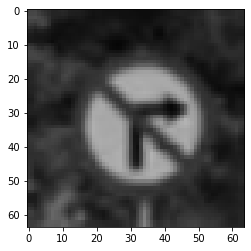

[577. 637.] [493. 571.]
(2, 64, 64)
[0.11944705 0.13856933 0.19121222 ... 0.067587   0.06679692 0.0786939 ]
(1, 0)


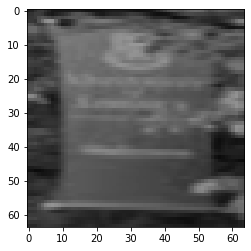

(2, 64, 64)
[0.11944705 0.13856933 0.19121222 ... 0.067587   0.06679692 0.0786939 ]
(1, 0)


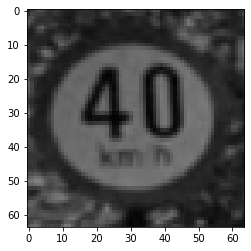

[161. 471. 415.] [  1. 336. 368.]
(3, 64, 64)
[0.18927892 0.22322858 0.23590234 ... 0.0792049  0.07659107 0.07733788]
(1, 0)


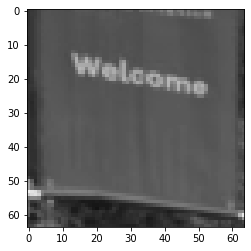

(3, 64, 64)
[0.18927892 0.22322858 0.23590234 ... 0.0792049  0.07659107 0.07733788]
(1, 0)


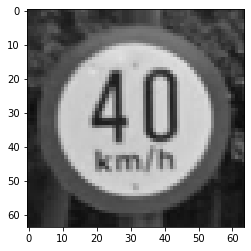

(3, 64, 64)
[0.18927892 0.22322858 0.23590234 ... 0.0792049  0.07659107 0.07733788]
(1, 0)


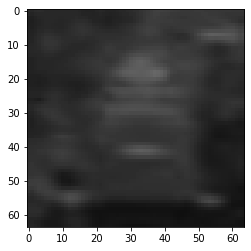

[383.] [302.]
(1, 64, 64)
[0.147538   0.12253704 0.1067579  ... 0.17245732 0.18357137 0.21321253]
(1, 0)


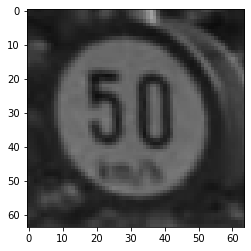

[550.] [488.]
(1, 64, 64)
[0.77262862 0.77267266 0.77518875 ... 0.73279676 0.73279676 0.73279676]
(1, 0)


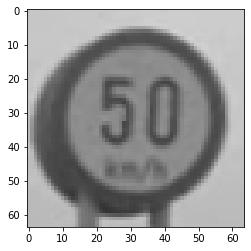

[477.] [363.]
(1, 64, 64)
[0.35403036 0.34024832 0.54504777 ... 0.41800821 0.37804995 0.43382748]
(1, 0)


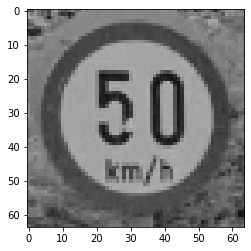

[752. 757.] [690. 699.]
(2, 64, 64)
[0.32809565 0.30695427 0.31637353 ... 0.44495778 0.45048963 0.45481565]
(1, 0)


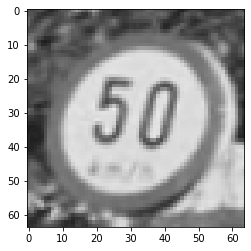

(2, 64, 64)
[0.32809565 0.30695427 0.31637353 ... 0.44495778 0.45048963 0.45481565]
(1, 0)


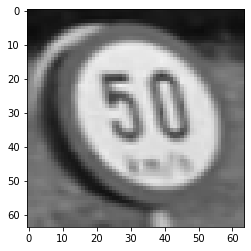

[687.] [633.]
(1, 64, 64)
[0.40847341 0.4008241  0.37795785 ... 0.37112244 0.39614359 0.41070805]
(1, 0)


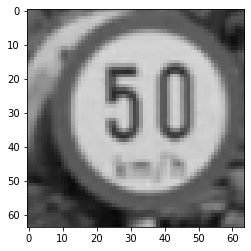

[460.] [381.]
(1, 64, 64)
[0.97724628 0.97846065 0.9808477  ... 0.78063797 0.75790492 0.73960614]
(1, 0)


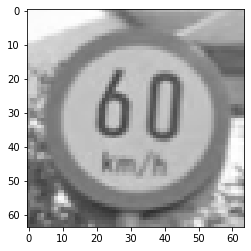

[319.] [245.]
(1, 64, 64)
[0.23437167 0.2405552  0.24048157 ... 0.2565787  0.20325329 0.16936156]
(1, 0)


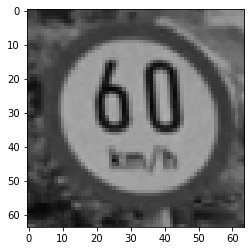

[711.] [658.]
(1, 64, 64)
[0.45481296 0.34487347 0.26786351 ... 0.07419397 0.09774515 0.10333312]
(1, 0)


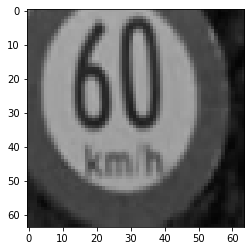

[664. 683.] [606. 615.]
(2, 64, 64)
[0.64945666 0.63394377 0.63493602 ... 0.1401083  0.13864027 0.15412549]
(1, 0)


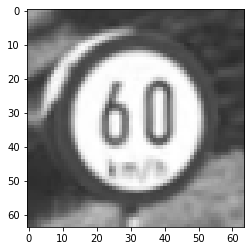

(2, 64, 64)
[0.64945666 0.63394377 0.63493602 ... 0.1401083  0.13864027 0.15412549]
(1, 0)


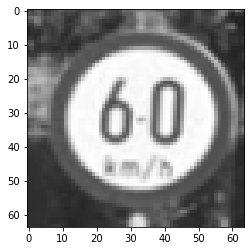

[716.] [631.]
(1, 64, 64)
[0.46921922 0.46921922 0.46921922 ... 0.7146084  0.71427531 0.71594439]
(1, 0)


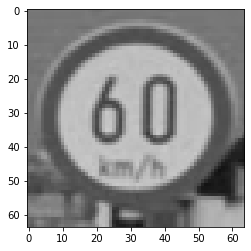

[381. 366. 411. 477. 495. 491.] [239. 304. 352. 404. 410. 457.]
(6, 64, 64)
[0.56401907 0.53352786 0.48403768 ... 0.21413235 0.24749251 0.23159833]
(1, 0)


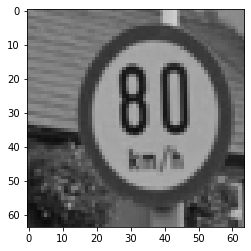

(6, 64, 64)
[0.56401907 0.53352786 0.48403768 ... 0.21413235 0.24749251 0.23159833]
(1, 0)


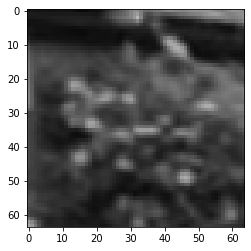

(6, 64, 64)
[0.56401907 0.53352786 0.48403768 ... 0.21413235 0.24749251 0.23159833]
(1, 0)


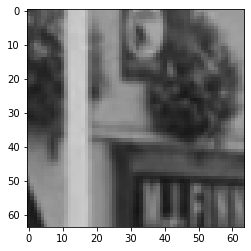

(6, 64, 64)
[0.56401907 0.53352786 0.48403768 ... 0.21413235 0.24749251 0.23159833]
(1, 0)


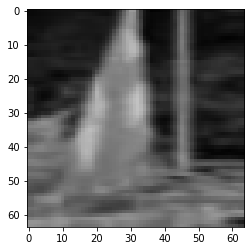

(6, 64, 64)
[0.56401907 0.53352786 0.48403768 ... 0.21413235 0.24749251 0.23159833]
(1, 0)


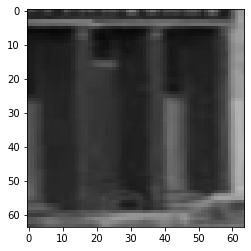

(6, 64, 64)
[0.56401907 0.53352786 0.48403768 ... 0.21413235 0.24749251 0.23159833]
(1, 0)


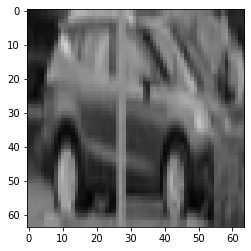

[483.] [428.]
(1, 64, 64)
[0.35989967 0.35701937 0.34297114 ... 0.28119157 0.26557884 0.25822264]
(1, 0)


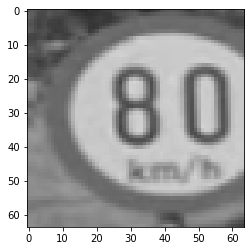

[698. 779.] [627. 677.]
(2, 64, 64)
[0.41105364 0.43021359 0.43647744 ... 0.31804156 0.3151907  0.31268591]
(1, 0)


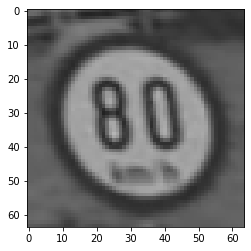

(2, 64, 64)
[0.41105364 0.43021359 0.43647744 ... 0.31804156 0.3151907  0.31268591]
(1, 0)


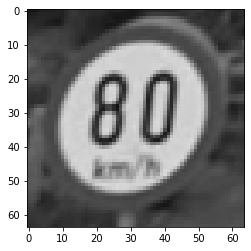

[671. 666.] [581. 596.]
(2, 64, 64)
[0.34962173 0.47806138 0.38748665 ... 0.37190541 0.40824681 0.47512809]
(1, 0)


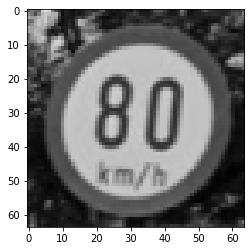

(2, 64, 64)
[0.34962173 0.47806138 0.38748665 ... 0.37190541 0.40824681 0.47512809]
(1, 0)


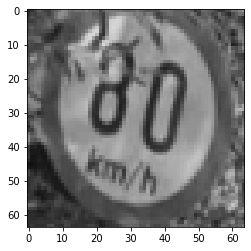

[541.] [381.]
(1, 64, 64)
[0.48210673 0.39518029 0.417498   ... 0.46162155 0.38998972 0.3062815 ]
(1, 0)


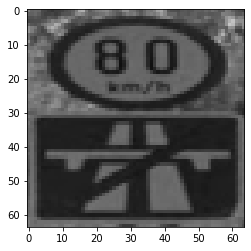

[392. 382.] [348. 352.]
(2, 64, 64)
[0.4329863  0.45119779 0.45983633 ... 0.42767612 0.43801448 0.4403119 ]
(1, 0)


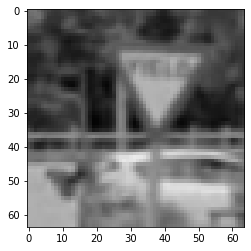

(2, 64, 64)
[0.4329863  0.45119779 0.45983633 ... 0.42767612 0.43801448 0.4403119 ]
(1, 0)


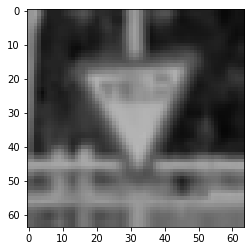

The total detection RoIs: 
48


In [17]:
'''images = load_images_from_folder('./speed-sign-test-images/')
images = np.array(images)
print(images.shape)
k = 0
for i in range(0, images.shape[0]):
    speed_signs = Speed_sign_detector(images[i,:,:,:])
    speed_signs = np.array(speed_signs)
    print(i)
    for j in range(0,speed_signs.shape[0]):
        print(speed_signs.shape)
        #imutils.imshow(speed_signs[j,:,:,:])

#speed_sign = Speed_sign_detector(images[6,:,:,:])
#imutils.imshow(speed_sign)
'''
speed_imgaes = load_images_from_folder('./speed-sign-test-images/')
speed_images = np.array(speed_imgaes)

all_images_data = np.array([[]])

detectionCount = 0;
#for i in range(0,2):

# Just for test the method
for i in range(0, speed_images.shape[0]):
    
    # Call method
    speed_signs, Xmax, Xmin, _, _ = speed_sign_detector(speed_images[i,:,:,:])
    speed_signs = np.array(speed_signs)
    print(Xmax, Xmin)
    # Go thought all ROIs
    for j in range(0,speed_signs.shape[0]):
        #speed_signs = rgb2gray(speed_signs[j,:,:])
        detectionCount = detectionCount + 1
        print(speed_signs.shape)
        signs_array_flatten = speed_signs.flatten()
        np.append([all_images_data], [signs_array_flatten])
        
        print(signs_array_flatten)
        print(all_images_data.shape)
        imutils.imshow(speed_signs[j,:,:])
print("The total detection RoIs: ")
print(detectionCount)